In [ ]:
# 라이브러리 임포트

from google.cloud import bigquery
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

라이브러리 임포트 완료!


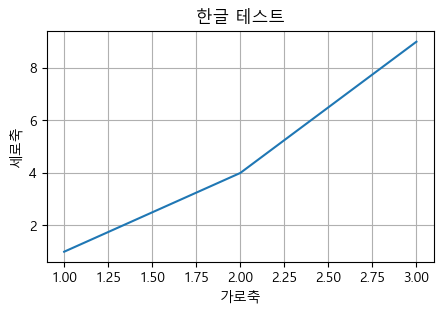

In [ ]:
# 시각화 설정

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(5, 3))
plt.plot([1, 2, 3], [1, 4, 9])
plt.title("한글 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.grid(True)
plt.show()

In [ ]:
# BigQuery 연결 설정

client = bigquery.Client()

PROJECT_ID = 'sesac-sd-bigquery-478605'  
DATASET = 'project'        

print(f"프로젝트: {PROJECT_ID}")
print(f"데이터셋: {DATASET}")

프로젝트: sesac-sd-bigquery-478605
데이터셋: project


In [ ]:
# 전체 퍼널 전환율

query = f"""
SELECT 
    action,
    COUNT(*) as cnt
FROM `{PROJECT_ID}.{DATASET}.events`
WHERE action IN ('view_item', 'add_to_cart', 'begin_checkout', 'purchase')
GROUP BY action
"""

df_funnel = client.query(query).to_dataframe()

# 순서 정렬
order = ['view_item', 'add_to_cart', 'begin_checkout', 'purchase']
df_funnel['action'] = pd.Categorical(df_funnel['action'], categories=order, ordered=True)
df_funnel = df_funnel.sort_values('action').reset_index(drop=True)

# 전환율 계산
df_funnel['conversion_rate'] = df_funnel['cnt'] / df_funnel['cnt'].iloc[0] * 100
df_funnel

,action,cnt,conversion_rate
0,view_item,3840041,100.0
1,add_to_cart,1351459,35.193869
2,begin_checkout,516026,13.438034
3,purchase,384060,10.001456


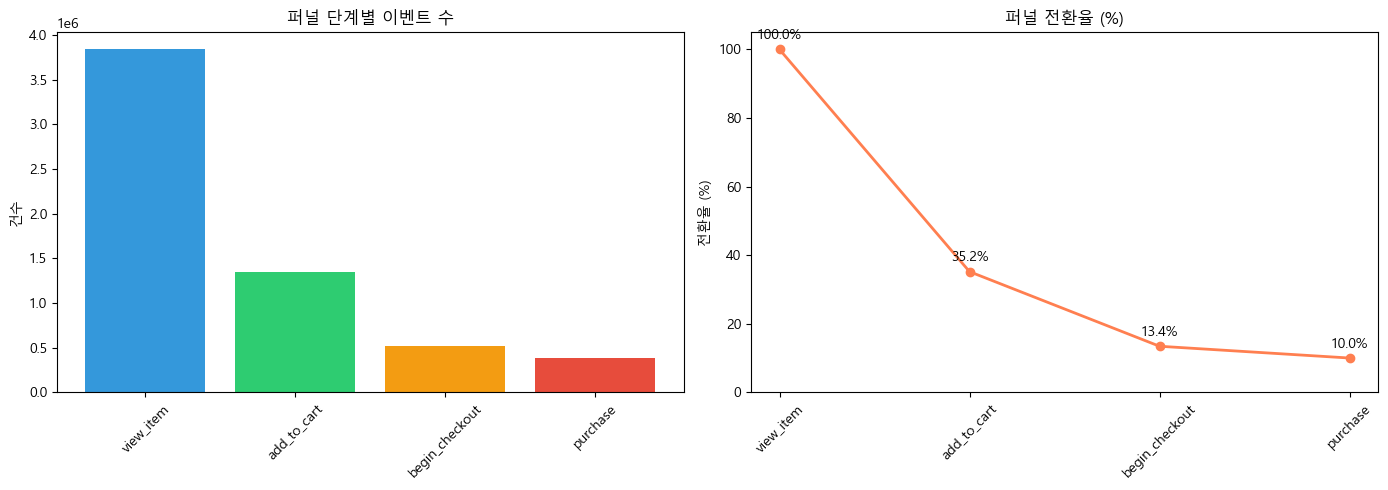

In [ ]:
# 퍼널 시각화

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 막대 그래프
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(df_funnel['action'], df_funnel['cnt'], color=colors)
axes[0].set_title('퍼널 단계별 이벤트 수')
axes[0].set_ylabel('건수')
axes[0].tick_params(axis='x', rotation=45)

# 전환율 그래프
axes[1].plot(df_funnel['action'], df_funnel['conversion_rate'], marker='o', linewidth=2, color='coral')
axes[1].set_title('퍼널 전환율 (%)')
axes[1].set_ylabel('전환율 (%)')
axes[1].set_ylim(0, 105)
axes[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(df_funnel['conversion_rate']):
    axes[1].text(i, v + 3, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# 단계별 전환율 

df_funnel['step_conversion'] = df_funnel['cnt'] / df_funnel['cnt'].shift(1) * 100
df_funnel['step_name'] = ['시작', 'view→cart', 'cart→checkout', 'checkout→purchase']
df_funnel[['action', 'cnt', 'step_conversion', 'step_name']]

,action,cnt,step_conversion,step_name
0,view_item,3840041,<NA>,시작
1,add_to_cart,1351459,35.193869,view→cart
2,begin_checkout,516026,38.182882,cart→checkout
3,purchase,384060,74.426482,checkout→purchase


In [ ]:
# MBTI별 퍼널 전환율

query = f"""
SELECT 
    u.mbti,
    e.action,
    COUNT(*) as cnt
FROM `{PROJECT_ID}.{DATASET}.events` e
JOIN `{PROJECT_ID}.{DATASET}.users` u ON e.user_id = u.user_id
WHERE e.action IN ('view_item', 'add_to_cart', 'begin_checkout', 'purchase')
GROUP BY u.mbti, e.action
"""

df_mbti_funnel = client.query(query).to_dataframe()
df_mbti_funnel_pivot = df_mbti_funnel.pivot(index='mbti', columns='action', values='cnt').reset_index()
df_mbti_funnel_pivot = df_mbti_funnel_pivot[['mbti', 'view_item', 'add_to_cart', 'begin_checkout', 'purchase']]

# 전환율 계산
df_mbti_funnel_pivot['view_to_cart'] = (df_mbti_funnel_pivot['add_to_cart'] / df_mbti_funnel_pivot['view_item'] * 100).round(2)
df_mbti_funnel_pivot['cart_to_checkout'] = (df_mbti_funnel_pivot['begin_checkout'] / df_mbti_funnel_pivot['add_to_cart'] * 100).round(2)
df_mbti_funnel_pivot['checkout_to_purchase'] = (df_mbti_funnel_pivot['purchase'] / df_mbti_funnel_pivot['begin_checkout'] * 100).round(2)

df_mbti_funnel_pivot

action,mbti,view_item,add_to_cart,begin_checkout,purchase,view_to_cart,cart_to_checkout,checkout_to_purchase
0,ENFJ,264877,80243,40383,34727,30.29,50.33,85.99
1,ENFP,475761,237317,65887,44492,49.88,27.76,67.53
2,ENTJ,137936,34874,22664,19527,25.28,64.99,86.16
3,ENTP,231229,94158,32348,21704,40.72,34.36,67.1
4,ESFJ,410585,111978,55181,47405,27.27,49.28,85.91
5,ESFP,537164,284121,71165,48152,52.89,25.05,67.66
6,ESTJ,154510,22738,17974,15439,14.72,79.05,85.9
7,ESTP,125262,56735,51684,35106,45.29,91.1,67.92
8,INFJ,110841,17155,11918,10279,15.48,69.47,86.25
9,INFP,262596,95669,37572,25406,36.43,39.27,67.62


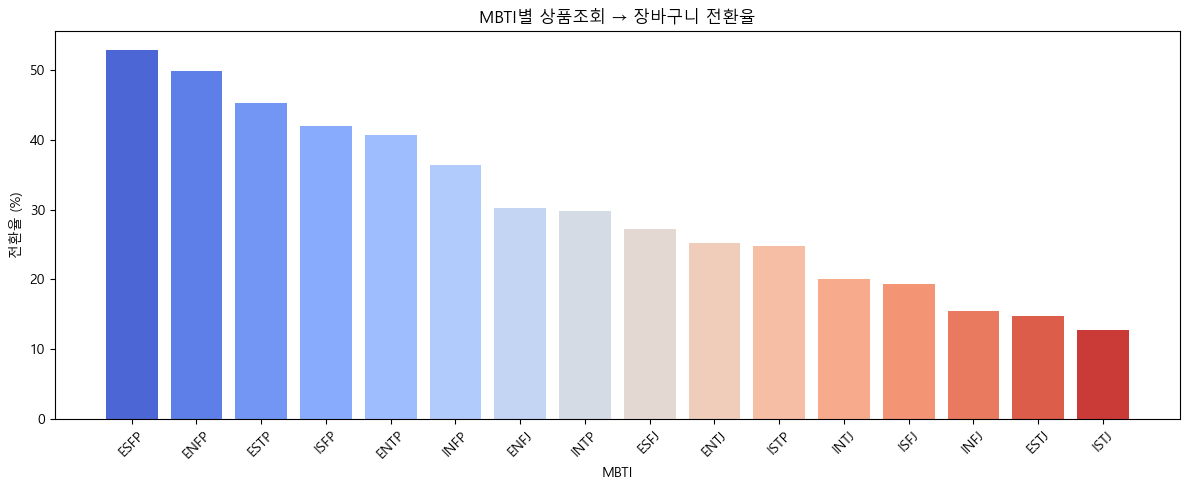

In [ ]:
# MBTI별 view → cart 전환율

df_sorted = df_mbti_funnel_pivot.sort_values('view_to_cart', ascending=False)

plt.figure(figsize=(12, 5))
colors = sns.color_palette('coolwarm', 16)
plt.bar(df_sorted['mbti'], df_sorted['view_to_cart'], color=colors)
plt.title('MBTI별 상품조회 → 장바구니 전환율')
plt.xlabel('MBTI')
plt.ylabel('전환율 (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# J/P 축별 결제 이탈률

query = f"""
SELECT 
    u.mbti_j_p,
    COUNT(CASE WHEN e.action = 'begin_checkout' THEN 1 END) as checkout_started,
    COUNT(CASE WHEN e.action = 'purchase' THEN 1 END) as purchased,
    COUNT(CASE WHEN e.action = 'checkout_abandon' THEN 1 END) as abandoned
FROM `{PROJECT_ID}.{DATASET}.events` e
JOIN `{PROJECT_ID}.{DATASET}.users` u ON e.user_id = u.user_id
WHERE e.action IN ('begin_checkout', 'purchase', 'checkout_abandon')
GROUP BY u.mbti_j_p
"""

df_jp = client.query(query).to_dataframe()
df_jp['checkout_abandon_rate'] = ((df_jp['checkout_started'] - df_jp['purchased']) / df_jp['checkout_started'] * 100).round(2)
df_jp

,mbti_j_p,checkout_started,purchased,abandoned,checkout_abandon_rate
0,P,348246,235315,112931,32.43
1,J,203995,175396,28599,14.02


In [ ]:
# 확인 쿼리
query = f"""
SELECT 
    u.mbti_t_f,
    s.campaign_type,
    s.is_converted,
    COUNT(*) as cnt
FROM `{PROJECT_ID}.{DATASET}.sessions` s
JOIN `{PROJECT_ID}.{DATASET}.users` u ON s.user_id = u.user_id
WHERE s.campaign_type IS NOT NULL
GROUP BY u.mbti_t_f, s.campaign_type, s.is_converted
ORDER BY u.mbti_t_f, s.campaign_type, s.is_converted
"""

client.query(query).to_dataframe()

,mbti_t_f,campaign_type,is_converted,cnt
0,F,emotional,False,38783
1,F,emotional,True,19123
2,F,rational,False,51736
3,F,rational,True,6215
4,T,emotional,False,36643
5,T,emotional,True,5327
6,T,rational,False,33279
7,T,rational,True,8905


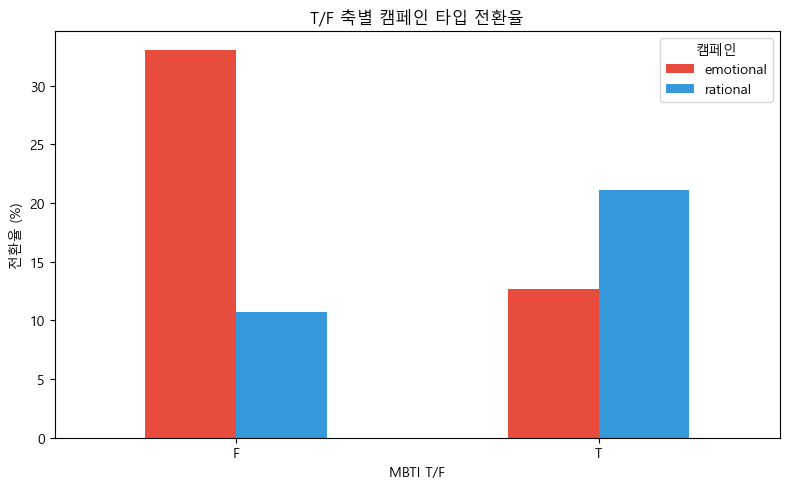

F: 감성 캠페인 33%, 이성 캠페인 11%
T: 이성 캠페인 21%, 감성 캠페인 13%


In [ ]:
# T/F 캠페인 타입 전환율 시각화

query = f"""
SELECT 
    u.mbti_t_f,
    s.campaign_type,
    COUNT(*) as sessions,
    SUM(CASE WHEN s.is_converted = TRUE THEN 1 ELSE 0 END) as converted,
    ROUND(SUM(CASE WHEN s.is_converted = TRUE THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as cvr
FROM `{PROJECT_ID}.{DATASET}.sessions` s
JOIN `{PROJECT_ID}.{DATASET}.users` u ON s.user_id = u.user_id
WHERE s.campaign_type IS NOT NULL
GROUP BY u.mbti_t_f, s.campaign_type
"""

df_tf = client.query(query).to_dataframe()
df_pivot = df_tf.pivot(index='mbti_t_f', columns='campaign_type', values='cvr')

df_pivot.plot(kind='bar', figsize=(8, 5), color=['#e74c3c', '#3498db'])
plt.title('T/F 축별 캠페인 타입 전환율')
plt.xlabel('MBTI T/F')
plt.ylabel('전환율 (%)')
plt.legend(title='캠페인')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("F: 감성 캠페인 33%, 이성 캠페인 11%")
print("T: 이성 캠페인 21%, 감성 캠페인 13%")